# <center> Identify Customer Segments- Machine Learning </center>

## Table of Contents

1. <a href="#Intro">Introduction</a>
2. <a href="#Trans">Feature Transformation</a>
    * <a href="#Scale"> 2.1 - Apply Feature Scaling </a>
    * <a href="#Dimen"> 2.2 - Perform Dimensionality Reduction </a>
    * <a href="#Inter"> 2.3 - Interpret Principal Components </a>
3. <a href="#Clust">Clustering </a>
    * <a href="#Gener"> 3.1 - Apply Clustering to General Population </a>
    * <a href="#Custo"> 3.2 - Apply All Steps to the Customer Data </a>
    * <a href="#Compa"> 3.3 - Compare Customer Data to Demographics Data </a>

<a id = 'Intro'></a>
## Introduction

Based on the [data cleansing](http://localhost:8888/notebooks/Identify_Customer_Segments_Exploration.ipynb)  notebook, we now have a solid understanding of the data under consideration. _In this notebook_, we load the previously cleaned data then we proceed with the <u>_feature transformation_</u> as well as the <u>_clustering parts_</u> of this project. We conclude this analysis by applying the whole pipeline for an another dataset containing the same demographic data about specific customers in a trial of analysing the common patterns associated with the general population. Hopefully, this process will lead to a better understanding of the customer behaviours in shadow of the available data about general population. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import do_pca, scree_plot, pca_results, map_weights,fit_kmeans, clean_data
from sklearn.cluster import KMeans

<a id = 'Clean'></a>
### 2 -  Load cleaned dataset

The complete data cleaning procedure and detailed justification for each step is given on the [Data Cleansing notebook](http://localhost:8888/notebooks/Identify_Customer_Segments_Exploration.ipynb). To simplify this notebook, we just load the resulted dataframe. 

In [2]:
azdias_cleaned = pd.read_csv('Udacity_AZDIAS_Subset_Cleaned.csv', index_col = 0)
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,x11_9A,x11_9B,x11_9C,x11_9D,x11_9E,x12_O,x12_W,movement,Waelth,LifeStage
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,1
1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,4
2,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,3
3,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5,4
4,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,2


In [3]:
original_feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
original_feat_info.index = original_feat_info.attribute
original_feat_info.drop('attribute', axis = 1, inplace = True)

<a id = 'Trans'></a>
## 3 - Feature Transformation

<a id = 'Scale'></a>
### 3.1 -  Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. In this substep, we perform a standard scaling so that all the features have a mean of 0 and a standard deviation of 1. 

In [4]:
# Apply feature scaling to the general population demographics data.
Sclaer_obj = StandardScaler()
azdias2 = pd.DataFrame(Sclaer_obj.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns)

<a id = 'Dimen'></a>
### 3.2 - Perform Dimensionality Reduction

On the scaled data, we are now ready to apply dimensionality reduction techniques. Below is a summary of upcoming procedure. 

- Using sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class, we apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed).
- Checking out the ratio of variance explained by each principal component as well as the cumulative variance explained. In addition, we plot the cumulative values. Based on the findings, we select a value for the number of transformed features to retain for the clustering part.
- Finally, we re-fit a PCA instance to perform the decided-on transformation on the selected number of the features.

In [5]:
# Apply PCA to the whole scaled data.
pca, X_pca = do_pca(n_components = azdias_cleaned.shape[1], data = azdias2)

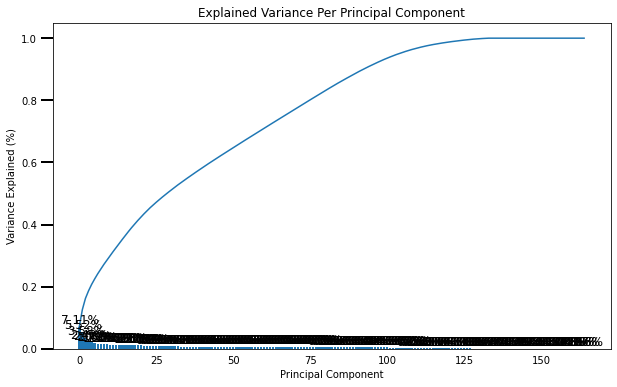

In [6]:
# Investigate the variance accounted for by each principal component.
vals,cumvals = scree_plot(pca)

Having completed the PCA analysis using all the features, we retain specific number of components to facilitate the upcoming clustering as possible. Thus, we need to keep number of the features which results in explaining specific threshold of the original data's variance.  

In [7]:
# Re-apply PCA to the data while selecting for number of components to retain.
threshold_PCA_retain = .8
comp_to_retain = np.where(cumvals <= threshold_PCA_retain)[0][-1]
pca, X_pca = do_pca(n_components = comp_to_retain, data = azdias_cleaned)
FinalPCAresults = pca_results(azdias_cleaned, pca)

In [8]:
FinalPCAresults.shape

(74, 166)

Selecting to retain the principal components explaining `80%` of the variance in the dataset lead to have new data with only `83` columns. 

<a id = 'Inter'></a>
### 3.3 -  Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In a nutshell, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list.
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we wrote a function `map_weights` to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [9]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights2 = map_weights(FinalPCAresults, 2)
weights2

SEMIO_VERT    0.3363
SEMIO_FAM     0.2804
SEMIO_SOZ     0.2767
SEMIO_KULT    0.2662
x1_5.0        0.1479
               ...  
SEMIO_RAT    -0.1733
SEMIO_ERL    -0.2123
SEMIO_KRIT   -0.2799
SEMIO_DOM    -0.3103
SEMIO_KAEM   -0.3345
Name: Dimension 3, Length: 166, dtype: float64

In [10]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights3 = map_weights(FinalPCAresults, 3)
weights3

ANZ_PERSONEN    0.2620
EWDICHTE        0.2482
x4_5.0          0.2367
x5_10.0         0.1935
x6_5.0          0.1935
                 ...  
BALLRAUM       -0.1985
INNENSTADT     -0.2057
x6_4.0         -0.2068
x3_1.0         -0.2877
x4_1.0         -0.2877
Name: Dimension 4, Length: 166, dtype: float64

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

<a id = 'Clust'></a>
## 4 -  Clustering

<a id = 'Gener'></a>
### 4.1 - Apply Clustering to General Population

Having assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

A summary of the upcoming procedure is given below
-  Performing k-means clustering on the PCA-transformed data using sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).
- Computing the average difference from each point to its assigned cluster's center. 
- Performing the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Using this fact, we select a final number of clusters in which to group the data.
- Having selected a final number of clusters to use, we re-fit a KMeans instance to perform the clustering operation.

In [11]:
X_pca[0:1000].shape

(1000, 74)

In [12]:
centers_1 = np.arange(20,30)
scores_1 = []
for k in centers_1:
    model = KMeans(n_clusters = k)
    model.fit(X_pca[0:1000])
    scores_1.append(np.abs(model.score(X_pca[0:1000])))

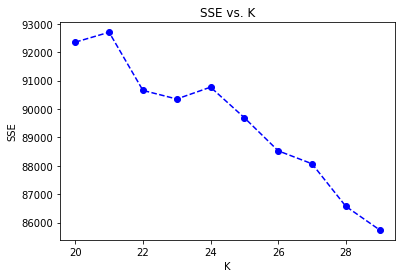

In [13]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(centers_1, scores_1, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [14]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_best = 25
labels,Kmeans_obj = fit_kmeans(X_pca[0:1000], k_best) #fit kmeans to get the labels

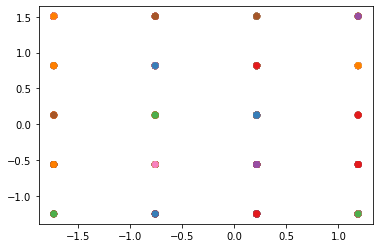

In [15]:
# Plot the original data with clusters
plt.scatter(azdias2['ALTERSKATEGORIE_GROB'].iloc[0:1000], azdias2['FINANZ_ANLEGER'].iloc[0:1000], c=labels, cmap='Set1');

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

<a id = 'Custo'></a>
### 5.2 -  Apply All Steps to the Customer Data

Now we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. In the last step of the project, we will interpret how the general population fits apply to the customer data.

A summary of the upcoming procedure is given below:
- Loading the customer data
- Applying the same cleansing pipeline done with the general population data
- Applying the same feature transformation steps (i.e., scaling and pca) using the objects obtained previosuly. 
- Finally, clustering the tranformed data using the same clustering object. 

In [17]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [19]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers,original_feat_info)

Data cleansing pipeline...
	1-Replacing missing values per column with Nan...
		Replacing done
	2-Removing the outliars columns and rows...
		Removing the outliars columns and rows done
	3-Feature Engineering...
bin_cat is ['OST_WEST_KZ']
Missing values by column : CJT_GESAMTTYP       3123
FINANZTYP              0
GFK_URLAUBERTYP     3123
LP_FAMILIE_FEIN     9397
LP_FAMILIE_GROB     9397
LP_STATUS_FEIN      3123
LP_STATUS_GROB      3123
NATIONALITAET_KZ    2105
SHOPPER_TYP         2338
ZABEOTYP               0
CAMEO_DEUG_2015     3189
CAMEO_DEU_2015      3189
OST_WEST_KZ         2563
dtype: int64
		Feature Engineering done
	4-Removing missing values...
		Removing missing values done.
Cleaning pipeline done


In [20]:
azdias_cleaned.shape, customers_cleaned.shape

((700781, 165), (131167, 165))

In [22]:
customers_scaled = pd.DataFrame(Sclaer_obj.transform(customers_cleaned), columns = customers_cleaned.columns)
customers_scaled

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,x11_9A,x11_9B,x11_9C,x11_9D,x11_9E,x12_O,x12_W,movement,Waelth,LifeStage
0,1.189108,1.395242,-1.155893,1.135148,-1.252721,-0.448381,-0.767295,-1.603396,1.101379,0.921721,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,-1.522191,0.075540
1,1.189108,1.395242,-1.155893,1.135148,-1.252721,0.995122,0.664538,-0.279699,1.101379,-1.126994,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,-0.157527,0.751356
2,0.214181,-0.069741,-1.155893,0.412379,0.817391,1.716874,-0.767295,1.043998,1.101379,-0.102637,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,0.524805,-1.276091
3,0.214181,1.395242,-1.155893,1.135148,-1.252721,-0.448381,-0.051378,1.043998,-0.278312,0.921721,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,-0.157527,0.751356
4,1.189108,1.395242,-1.155893,1.135148,-1.252721,-1.170132,-0.767295,-0.279699,1.101379,-0.102637,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,-0.839859,0.075540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131162,-0.760746,-0.802233,-1.155893,1.135148,-1.252721,-0.448381,1.380455,-0.279699,1.101379,-1.126994,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,-1.522191,0.751356
131163,0.214181,1.395242,-1.155893,1.135148,-1.252721,-1.170132,-0.767295,1.043998,1.101379,0.921721,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,-1.522191,0.751356
131164,1.189108,1.395242,-1.155893,1.135148,-1.252721,-1.170132,-0.767295,-0.279699,-0.278312,-0.102637,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,-0.839859,0.751356
131165,0.214181,-0.802233,-1.155893,1.135148,-1.252721,-0.448381,1.380455,-0.279699,1.101379,-0.102637,...,-0.160995,-0.188293,-0.176486,-0.188829,-0.076318,-0.525822,0.525822,-0.754823,-0.839859,0.751356


In [23]:
customers_transformed = pca.transform(customers_scaled)
customers_labels = Kmeans_obj.transform(customers_transformed)

In [27]:
customers_labels

array([[14.19874128, 16.13699552, 14.37804229, ..., 20.42558751,
        15.58359708, 13.68691204],
       [13.32178563, 13.82074671, 13.59288388, ..., 18.360913  ,
        13.90855292, 11.71229731],
       [14.72308919, 14.5224832 , 13.75531965, ..., 20.08362412,
        15.47553879, 12.51428542],
       ...,
       [13.10110698, 14.2812737 , 13.27513191, ..., 19.10939034,
        15.20804608, 12.0307909 ],
       [12.5718027 , 12.82785194, 12.50498041, ..., 18.43953731,
        13.99137805, 11.36129853],
       [13.57937884, 14.49435093, 13.4626847 , ..., 18.40029257,
         8.14781727, 11.75720241]])

<a id = 'Compa'></a>
### 5.3 - Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [24]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [25]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [26]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.